# Method 3 - Best Ideas Medium Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['size_pct'] > (1 / 3)) & (best_ideas['size_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

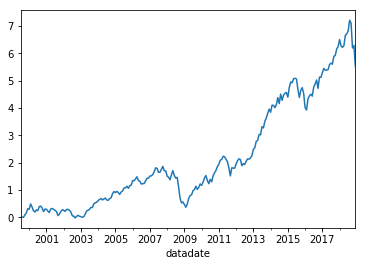

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.320904
2000-12-31   -0.010862
2001-12-31   -0.019314
2002-12-31   -0.186994
2003-12-31    0.493490
2004-12-31    0.250697
2005-12-31    0.120414
2006-12-31    0.117420
2007-12-31    0.109529
2008-12-31   -0.421101
2009-12-31    0.421794
2010-12-31    0.284875
2011-12-31   -0.021300
2012-12-31    0.163544
2013-12-31    0.522456
2014-12-31    0.122516
2015-12-31   -0.004940
2016-12-31    0.104402
2017-12-31    0.184398
2018-12-31   -0.100635
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     542.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.53e-115
Time:                        13:16:20   Log-Likelihood:                 637.22
No. Observations:                 234   AIC:                            -1264.
Df Residuals:                     229   BIC:                            -1247.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.420      0.001       0.002       0.006
mktrf          0.9563      0.030     31.924      0.000       0.897       1.015
me             0.4914      0.035     14.102      0.000       0.423       0.560
ia            -0.0554      0.053     -1.047      0.296      -0.160       0.049
roe            0.0001      0.045      0.003      0.998      -0.089       0.089
==============================================================================
Omnibus:                       20.037   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.985
Skew:                          -0.218   Prob(JB):                     2.10e-14
Kurtosis:                       5.504   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     543.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.23e-115
Time:                        13:16:20   Log-Likelihood:                 637.22
No. Observations:                 234   AIC:                            -1264.
Df Residuals:                     229   BIC:                            -1247.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.687      0.000       0.002       0.006
mktrf          0.9563      0.042     22.852      0.000       0.874       1.038
me             0.4914      0.037     13.111      0.000       0.418       0.565
ia            -0.0554      0.111     -0.499      0.618      -0.273       0.162
roe            0.0001      0.068      0.002      0.998      -0.134       0.134
==============================================================================
Omnibus:                       20.037   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.985
Skew:                          -0.218   Prob(JB):                     2.10e-14
Kurtosis:                       5.504   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     642.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.73e-123
Time:                        13:16:20   Log-Likelihood:                 637.22
No. Observations:                 234   AIC:                            -1264.
Df Residuals:                     229   BIC:                            -1247.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.826      0.000       0.002       0.006
mktrf          0.9563      0.036     26.369      0.000       0.885       1.027
me             0.4914      0.037     13.341      0.000       0.419       0.564
ia            -0.0554      0.112     -0.493      0.622      -0.276       0.165
roe            0.0001      0.055      0.002      0.998      -0.107       0.107
==============================================================================
Omnibus:                       20.037   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.985
Skew:                          -0.218   Prob(JB):                     2.10e-14
Kurtosis:                       5.504   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     388.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.44e-109
Time:                        13:16:20   Log-Likelihood:                 625.84
No. Observations:                 234   AIC:                            -1240.
Df Residuals:                     228   BIC:                            -1219.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      3.249      0.001       0.001       0.006
mktrf          0.9650      0.032     30.559      0.000       0.903       1.027
smb            0.4918      0.042     11.803      0.000       0.410       0.574
hml           -0.0805      0.049     -1.638      0.103      -0.177       0.016
rmw           -0.0355      0.056     -0.639      0.524      -0.145       0.074
cma            0.1013      0.071      1.434      0.153      -0.038       0.240
==============================================================================
Omnibus:                       17.454   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.287
Skew:                          -0.146   Prob(JB):                     4.43e-12
Kurtosis:                       5.297   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     493.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.21e-120
Time:                        13:16:20   Log-Likelihood:                 625.84
No. Observations:                 234   AIC:                            -1240.
Df Residuals:                     228   BIC:                            -1219.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      2.962      0.003       0.001       0.006
mktrf          0.9650      0.043     22.389      0.000       0.881       1.050
smb            0.4918      0.050      9.834      0.000       0.394       0.590
hml           -0.0805      0.076     -1.053      0.292      -0.230       0.069
rmw           -0.0355      0.083     -0.425      0.671      -0.199       0.128
cma            0.1013      0.162      0.624      0.533      -0.217       0.419
==============================================================================
Omnibus:                       17.454   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.287
Skew:                          -0.146   Prob(JB):                     4.43e-12
Kurtosis:                       5.297   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     619.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.82e-130
Time:                        13:16:20   Log-Likelihood:                 625.84
No. Observations:                 234   AIC:                            -1240.
Df Residuals:                     228   BIC:                            -1219.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      2.849      0.004       0.001       0.006
mktrf          0.9650      0.042     22.983      0.000       0.883       1.047
smb            0.4918      0.051      9.654      0.000       0.392       0.592
hml           -0.0805      0.082     -0.983      0.326      -0.241       0.080
rmw           -0.0355      0.087     -0.410      0.682      -0.205       0.134
cma            0.1013      0.179      0.566      0.572      -0.250       0.452
==============================================================================
Omnibus:                       17.454   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.287
Skew:                          -0.146   Prob(JB):                     4.43e-12
Kurtosis:                       5.297   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     506.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.10e-112
Time:                        13:16:20   Log-Likelihood:                 629.83
No. Observations:                 234   AIC:                            -1250.
Df Residuals:                     229   BIC:                            -1232.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      2.950      0.004       0.001       0.005
mktrf          1.0194      0.028     35.811      0.000       0.963       1.075
smb            0.4418      0.036     12.432      0.000       0.372       0.512
hml            0.0706      0.035      2.001      0.047       0.001       0.140
umd            0.1057      0.023      4.564      0.000       0.060       0.151
==============================================================================
Omnibus:                       14.675   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               40.895
Skew:                           0.000   Prob(JB):                     1.32e-09
Kurtosis:                       5.048   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     432.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.80e-105
Time:                        13:16:20   Log-Likelihood:                 629.83
No. Observations:                 234   AIC:                            -1250.
Df Residuals:                     229   BIC:                            -1232.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      2.864      0.004       0.001       0.005
mktrf          1.0194      0.039     26.016      0.000       0.943       1.096
smb            0.4418      0.044     10.001      0.000       0.355       0.528
hml            0.0706      0.074      0.949      0.342      -0.075       0.216
umd            0.1057      0.046      2.315      0.021       0.016       0.195
==============================================================================
Omnibus:                       14.675   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               40.895
Skew:                           0.000   Prob(JB):                     1.32e-09
Kurtosis:                       5.048   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     496.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.58e-111
Time:                        13:16:20   Log-Likelihood:                 629.83
No. Observations:                 234   AIC:                            -1250.
Df Residuals:                     229   BIC:                            -1232.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      2.885      0.004       0.001       0.005
mktrf          1.0194      0.035     29.044      0.000       0.951       1.088
smb            0.4418      0.039     11.255      0.000       0.365       0.519
hml            0.0706      0.075      0.941      0.347      -0.076       0.218
umd            0.1057      0.041      2.559      0.010       0.025       0.187
==============================================================================
Omnibus:                       14.675   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               40.895
Skew:                           0.000   Prob(JB):                     1.32e-09
Kurtosis:                       5.048   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     224.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.70e-53
Time:                        13:16:20   Log-Likelihood:                 302.04
No. Observations:                 120   AIC:                            -594.1
Df Residuals:                     115   BIC:                            -580.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.002      2.576      0.011       0.001       0.009
mktrf          1.0012      0.051     19.475      0.000       0.899       1.103
me             0.4860      0.051      9.571      0.000       0.385       0.587
ia            -0.0173      0.080     -0.217      0.829      -0.175       0.140
roe            0.0617      0.070      0.877      0.382      -0.078       0.201
==============================================================================
Omnibus:                        8.527   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               10.915
Skew:                          -0.394   Prob(JB):                      0.00426
Kurtosis:                       4.250   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     277.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.84e-58
Time:                        13:16:20   Log-Likelihood:                 302.04
No. Observations:                 120   AIC:                            -594.1
Df Residuals:                     115   BIC:                            -580.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.001      3.349      0.001       0.002       0.008
mktrf          1.0012      0.074     13.503      0.000       0.856       1.147
me             0.4860      0.052      9.281      0.000       0.383       0.589
ia            -0.0173      0.135     -0.128      0.898      -0.282       0.248
roe            0.0617      0.096      0.641      0.521      -0.127       0.250
==============================================================================
Omnibus:                        8.527   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               10.915
Skew:                          -0.394   Prob(JB):                      0.00426
Kurtosis:                       4.250   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     465.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.92e-70
Time:                        13:16:20   Log-Likelihood:                 302.04
No. Observations:                 120   AIC:                            -594.1
Df Residuals:                     115   BIC:                            -580.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.001      3.754      0.000       0.002       0.007
mktrf          1.0012      0.056     17.822      0.000       0.891       1.111
me             0.4860      0.053      9.104      0.000       0.381       0.591
ia            -0.0173      0.133     -0.130      0.897      -0.278       0.244
roe            0.0617      0.069      0.891      0.373      -0.074       0.197
==============================================================================
Omnibus:                        8.527   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               10.915
Skew:                          -0.394   Prob(JB):                      0.00426
Kurtosis:                       4.250   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     158.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.26e-49
Time:                        13:16:20   Log-Likelihood:                 296.05
No. Observations:                 120   AIC:                            -580.1
Df Residuals:                     114   BIC:                            -563.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.002      2.845      0.005       0.002       0.010
mktrf          1.0157      0.057     17.744      0.000       0.902       1.129
smb            0.4788      0.065      7.385      0.000       0.350       0.607
hml           -0.1336      0.079     -1.682      0.095      -0.291       0.024
rmw            0.0141      0.094      0.150      0.881      -0.172       0.200
cma            0.2053      0.103      2.000      0.048       0.002       0.409
==============================================================================
Omnibus:                        6.639   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                6.863
Skew:                          -0.397   Prob(JB):                       0.0323
Kurtosis:                       3.861   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     405.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.16e-71
Time:                        13:16:20   Log-Likelihood:                 296.05
No. Observations:                 120   AIC:                            -580.1
Df Residuals:                     114   BIC:                            -563.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.002      2.907      0.004       0.002       0.010
mktrf          1.0157      0.081     12.534      0.000       0.857       1.175
smb            0.4788      0.079      6.096      0.000       0.325       0.633
hml           -0.1336      0.118     -1.136      0.256      -0.364       0.097
rmw            0.0141      0.151      0.093      0.926      -0.283       0.311
cma            0.2053      0.208      0.985      0.325      -0.203       0.614
==============================================================================
Omnibus:                        6.639   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                6.863
Skew:                          -0.397   Prob(JB):                       0.0323
Kurtosis:                       3.861   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     621.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.13e-81
Time:                        13:16:20   Log-Likelihood:                 296.05
No. Observations:                 120   AIC:                            -580.1
Df Residuals:                     114   BIC:                            -563.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.002      2.928      0.003       0.002       0.010
mktrf          1.0157      0.080     12.689      0.000       0.859       1.173
smb            0.4788      0.081      5.893      0.000       0.320       0.638
hml           -0.1336      0.127     -1.050      0.294      -0.383       0.116
rmw            0.0141      0.167      0.084      0.933      -0.313       0.341
cma            0.2053      0.227      0.905      0.365      -0.239       0.650
==============================================================================
Omnibus:                        6.639   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                6.863
Skew:                          -0.397   Prob(JB):                       0.0323
Kurtosis:                       3.861   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     218.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.18e-53
Time:                        13:16:20   Log-Likelihood:                 300.76
No. Observations:                 120   AIC:                            -591.5
Df Residuals:                     115   BIC:                            -577.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.002      3.219      0.002       0.002       0.010
mktrf          1.0759      0.046     23.502      0.000       0.985       1.167
smb            0.3935      0.052      7.550      0.000       0.290       0.497
hml            0.0795      0.052      1.524      0.130      -0.024       0.183
umd            0.1388      0.032      4.314      0.000       0.075       0.203
==============================================================================
Omnibus:                        9.739   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               15.555
Skew:                          -0.351   Prob(JB):                     0.000419
Kurtosis:                       4.618   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     322.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.60e-61
Time:                        13:16:20   Log-Likelihood:                 300.76
No. Observations:                 120   AIC:                            -591.5
Df Residuals:                     115   BIC:                            -577.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.002      3.839      0.000       0.003       0.009
mktrf          1.0759      0.058     18.445      0.000       0.962       1.190
smb            0.3935      0.060      6.522      0.000       0.275       0.512
hml            0.0795      0.089      0.899      0.369      -0.094       0.253
umd            0.1388      0.053      2.644      0.008       0.036       0.242
==============================================================================
Omnibus:                        9.739   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               15.555
Skew:                          -0.351   Prob(JB):                     0.000419
Kurtosis:                       4.618   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     457.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.31e-69
Time:                        13:16:20   Log-Likelihood:                 300.76
No. Observations:                 120   AIC:                            -591.5
Df Residuals:                     115   BIC:                            -577.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.001      4.547      0.000       0.003       0.009
mktrf          1.0759      0.043     24.797      0.000       0.991       1.161
smb            0.3935      0.046      8.636      0.000       0.304       0.483
hml            0.0795      0.087      0.917      0.359      -0.090       0.250
umd            0.1388      0.039      3.550      0.000       0.062       0.216
==============================================================================
Omnibus:                        9.739   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               15.555
Skew:                          -0.351   Prob(JB):                     0.000419
Kurtosis:                       4.618   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     543.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.46e-71
Time:                        13:16:20   Log-Likelihood:                 369.12
No. Observations:                 114   AIC:                            -728.2
Df Residuals:                     109   BIC:                            -714.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.026      0.003       0.001       0.005
mktrf          0.9265      0.029     32.448      0.000       0.870       0.983
me             0.4949      0.044     11.226      0.000       0.407       0.582
ia            -0.2268      0.061     -3.709      0.000      -0.348      -0.106
roe           -0.1922      0.054     -3.578      0.001      -0.299      -0.086
==============================================================================
Omnibus:                        3.906   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.568
Skew:                           0.271   Prob(JB):                        0.168
Kurtosis:                       3.676   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     540.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.17e-71
Time:                        13:16:20   Log-Likelihood:                 369.12
No. Observations:                 114   AIC:                            -728.2
Df Residuals:                     109   BIC:                            -714.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.530      0.011       0.001       0.005
mktrf          0.9265      0.026     36.332      0.000       0.876       0.976
me             0.4949      0.036     13.580      0.000       0.423       0.566
ia            -0.2268      0.065     -3.510      0.000      -0.353      -0.100
roe           -0.1922      0.058     -3.306      0.001      -0.306      -0.078
==============================================================================
Omnibus:                        3.906   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.568
Skew:                           0.271   Prob(JB):                        0.168
Kurtosis:                       3.676   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     450.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.14e-67
Time:                        13:16:20   Log-Likelihood:                 369.12
No. Observations:                 114   AIC:                            -728.2
Df Residuals:                     109   BIC:                            -714.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.337      0.019       0.000       0.005
mktrf          0.9265      0.027     34.751      0.000       0.874       0.979
me             0.4949      0.032     15.277      0.000       0.431       0.558
ia            -0.2268      0.066     -3.416      0.001      -0.357      -0.097
roe           -0.1922      0.056     -3.452      0.001      -0.301      -0.083
==============================================================================
Omnibus:                        3.906   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.568
Skew:                           0.271   Prob(JB):                        0.168
Kurtosis:                       3.676   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     428.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.81e-69
Time:                        13:16:20   Log-Likelihood:                 368.82
No. Observations:                 114   AIC:                            -725.6
Df Residuals:                     108   BIC:                            -709.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.880      0.063   -9.96e-05       0.004
mktrf          0.9504      0.027     34.650      0.000       0.896       1.005
smb            0.4856      0.045     10.906      0.000       0.397       0.574
hml           -0.0444      0.057     -0.782      0.436      -0.157       0.068
rmw           -0.2193      0.070     -3.154      0.002      -0.357      -0.081
cma           -0.1656      0.088     -1.876      0.063      -0.341       0.009
==============================================================================
Omnibus:                        2.190   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.334   Jarque-Bera (JB):                1.746
Skew:                           0.292   Prob(JB):                        0.418
Kurtosis:                       3.166   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     351.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.17e-65
Time:                        13:16:20   Log-Likelihood:                 368.82
No. Observations:                 114   AIC:                            -725.6
Df Residuals:                     108   BIC:                            -709.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.526      0.127      -0.001       0.004
mktrf          0.9504      0.027     35.434      0.000       0.898       1.003
smb            0.4856      0.035     14.009      0.000       0.418       0.554
hml           -0.0444      0.050     -0.885      0.376      -0.143       0.054
rmw           -0.2193      0.067     -3.275      0.001      -0.351      -0.088
cma           -0.1656      0.090     -1.840      0.066      -0.342       0.011
==============================================================================
Omnibus:                        2.190   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.334   Jarque-Bera (JB):                1.746
Skew:                           0.292   Prob(JB):                        0.418
Kurtosis:                       3.166   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     365.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.64e-66
Time:                        13:16:20   Log-Likelihood:                 368.82
No. Observations:                 114   AIC:                            -725.6
Df Residuals:                     108   BIC:                            -709.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.396      0.163      -0.001       0.004
mktrf          0.9504      0.027     35.422      0.000       0.898       1.003
smb            0.4856      0.030     16.073      0.000       0.426       0.545
hml           -0.0444      0.047     -0.939      0.348      -0.137       0.048
rmw           -0.2193      0.060     -3.651      0.000      -0.337      -0.102
cma           -0.1656      0.083     -1.989      0.047      -0.329      -0.002
==============================================================================
Omnibus:                        2.190   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.334   Jarque-Bera (JB):                1.746
Skew:                           0.292   Prob(JB):                        0.418
Kurtosis:                       3.166   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     459.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.27e-67
Time:                        13:16:20   Log-Likelihood:                 360.02
No. Observations:                 114   AIC:                            -710.0
Df Residuals:                     109   BIC:                            -696.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.056      0.293      -0.001       0.003
mktrf          0.9747      0.029     33.257      0.000       0.917       1.033
smb            0.5312      0.046     11.625      0.000       0.441       0.622
hml           -0.0386      0.047     -0.819      0.414      -0.132       0.055
umd            0.0021      0.036      0.058      0.954      -0.068       0.072
==============================================================================
Omnibus:                        1.205   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.547   Jarque-Bera (JB):                0.885
Skew:                           0.210   Prob(JB):                        0.642
Kurtosis:                       3.104   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     356.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.33e-61
Time:                        13:16:20   Log-Likelihood:                 360.02
No. Observations:                 114   AIC:                            -710.0
Df Residuals:                     109   BIC:                            -696.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.807      0.419      -0.002       0.004
mktrf          0.9747      0.031     31.818      0.000       0.915       1.035
smb            0.5312      0.035     14.982      0.000       0.462       0.601
hml           -0.0386      0.035     -1.087      0.277      -0.108       0.031
umd            0.0021      0.025      0.083      0.934      -0.047       0.051
==============================================================================
Omnibus:                        1.205   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.547   Jarque-Bera (JB):                0.885
Skew:                           0.210   Prob(JB):                        0.642
Kurtosis:                       3.104   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     373.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.15e-62
Time:                        13:16:20   Log-Likelihood:                 360.02
No. Observations:                 114   AIC:                            -710.0
Df Residuals:                     109   BIC:                            -696.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.777      0.437      -0.002       0.004
mktrf          0.9747      0.029     33.236      0.000       0.917       1.032
smb            0.5312      0.032     16.400      0.000       0.468       0.595
hml           -0.0386      0.034     -1.145      0.252      -0.105       0.027
umd            0.0021      0.019      0.107      0.915      -0.036       0.040
==============================================================================
Omnibus:                        1.205   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.547   Jarque-Bera (JB):                0.885
Skew:                           0.210   Prob(JB):                        0.642
Kurtosis:                       3.104   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""